In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0293_4_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_7.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2511_4_13.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_9627_8_9.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_7_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2977_3_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_9_6.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2016_1_11.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2010_2_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_1424_5_16.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0472_10_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0471_3_5.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2015_11_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_7.jpg
/kaggle/input/surface-crack/valid

In [2]:
from IPython.display import clear_output
!pip install imutils
!pip install pycocotools 
clear_output()

## Importing Dependencies 

In [4]:
#importing dependencies 

import numpy as np 
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf 

import shutil
import itertools
import imutils

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

init_notebook_mode(connected=True)
RANDOM_SEED = 123

## Loading Data Images to Workspace

In [5]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [6]:
TRAIN_DIR = '/kaggle/input/surface-crack/train/'
TEST_DIR = '/kaggle/input/surface-crack/test/'
VAL_DIR = '/kaggle/input/surface-crack/valid/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


600 images loaded from /kaggle/input/surface-crack/train/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


200 images loaded from /kaggle/input/surface-crack/test/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

200 images loaded from /kaggle/input/surface-crack/valid/ directory.


## Saving images as np.array

In [7]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [8]:
!mkdir TRAIN_ TEST_ VAL_ TRAIN_/YES TRAIN_/NO TEST_/YES TEST_/NO VAL_/YES VAL_/NO

save_new_images(X_train, y_train, folder_name='TRAIN_/')
save_new_images(X_val, y_val, folder_name='VAL_/')
save_new_images(X_test, y_test, folder_name='TEST_/')

In [9]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [10]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

## Applying Data Augmentation 

In [11]:
TRAIN_DIR = '/kaggle/working/TRAIN_'
VAL_DIR = '/kaggle/working/VAL_'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Using VGG-16 Pretrained model to train data

In [22]:
# load base model
IMG_SIZE = (224,224)
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [23]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


## Fitting with Training data

In [24]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
10/10 [==============================] - 6s 521ms/step - loss: 13.8012 - accuracy: 0.6859 - val_loss: 6.9899 - val_accuracy: 0.6850
Epoch 2/30
10/10 [==============================] - 4s 442ms/step - loss: 7.3261 - accuracy: 0.8558
Epoch 3/30
10/10 [==============================] - 8s 764ms/step - loss: 4.6007 - accuracy: 0.9000
Epoch 4/30
10/10 [==============================] - 4s 430ms/step - loss: 3.9370 - accuracy: 0.9219
Epoch 5/30
10/10 [==============================] - 5s 480ms/step - loss: 2.4543 - accuracy: 0.9406
Epoch 6/30
10/10 [==============================] - 4s 415ms/step - loss: 5.9322 - accuracy: 0.8814
Epoch 7/30
10/10 [==============================] - 4s 453ms/step - loss: 9.8695 - accuracy: 0.8526
Epoch 8/30
10/10 [==============================] - 5s 467ms/step - loss: 4.3874 - accuracy: 0.9327
Epoch 9/30
10/10 [==============================] - 4s 428ms/step - loss: 2.9649 - accuracy: 0.9359
Epoch 10/30
10/10 [==============================] - 5s 4

## Confusion matrix for better visualization 

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Val Accuracy = 0.98


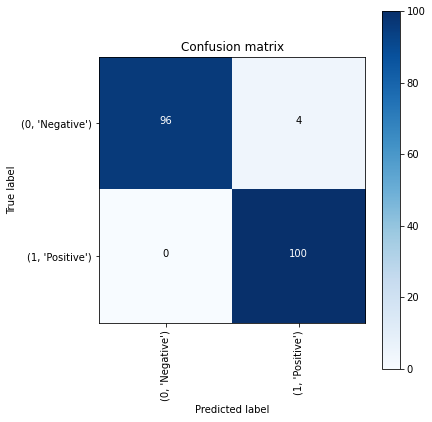

In [26]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [28]:
print(type(predictions), type(y_val))
predictions = np.array(predictions)

<class 'list'> <class 'numpy.ndarray'>


## Calculating f1_score on validation data 
![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/F1-scores-equation_1.png?resize=326%2C50&ssl=1](http://)
![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/F1-scores-equation_2-1.png?resize=232%2C50&ssl=1)
![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/F1-scores-equation_3-1.png?resize=366%2C50&ssl=1)


### For validation data
* recall = 1
* precision = 0.96153
* f1 = 0.98039638602

Val Accuracy = 0.98


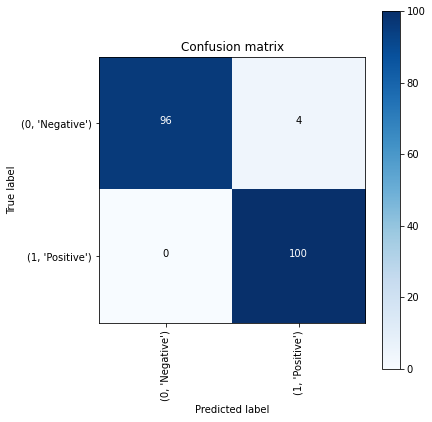

In [29]:
predictions_test = model.predict(X_test_prep)
predictions_test = [1 if x>0.5 else 0 for x in predictions]

accuracy_test = accuracy_score(y_test, predictions_test)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

## Predicting on predition images 

In [38]:
Pred_X = []
for file in os.listdir('/kaggle/input/surface-crack/predict'):
    img = cv2.imread('/kaggle/input/surface-crack/predict/' + file)
    Pred_X.append(img)

In [40]:
Pred_X =  preprocess_imgs(set_name=Pred_X, img_size=IMG_SIZE)

Pred_y = model.predict(Pred_X)
predictions_pred = [1 if x>0.5 else 0 for x in Pred_y]

In [41]:
predictions_test

[1, 1, 1, 1, 1, 1]